Install [nvdiffrast](https://nvlabs.github.io/nvdiffrast),
which we use as the interface between PyTorch and OpenGL.
```bash
# Don't forget to activate you python environment first
git clone https://github.com/NVlabs/nvdiffrast /tmp/nvdiffrast
pip install /tmp/nvdiffrast
rm -rf /tmp/nvdiffrast
```

In [ ]:
! cd workspace/pixel-perfect-sfm/outputs/dragon/projected_texture/exp2_before_ba |  
DISPLAY=:5 vglrun feh --force-aliasing --keep-zoom -dZV *


In [22]:
!chmod +x ./project_texture_on_mesh.py

!python3 project_texture_on_mesh.py -n white_piggybank -l 5 11 17 23 35 47 65 78 84

Experiment in /workspace/pixel-perfect-sfm/outputs/white_piggybank/query_localizer_optimum/query_localizer_v1/result
{0: Camera(id=0, model='PINHOLE', width=2368, height=1952, params=array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652]))}
  0%|                                                     | 0/3 [00:00<?, ?it/s]project_texture_on_mesh.py:155: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1614378083779/work/torch/csrc/utils/tensor_numpy.cpp:143.)
  img = torch.from_numpy(img).permute(2, 0, 1).to(dtype)  # [channels_n, height, width]
  0%|                                               

  0%|                                                     | 0/3 [00:00<?, ?it/s]/opt/miniconda3/envs/py38/lib/python3.8/site-packages/torch/nn/functional.py:3825: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.16it/s]


In [3]:
import torch
print(torch.version.cuda)import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

print(torch.cuda.is_available())

None
False


In [2]:
import sys

from PIL import Image
import numpy as np
import open3d as o3d
import torch
from tqdm.auto import tqdm

sys.path.append('/workspace/dev.sk_robot_rgbd_data/src')
from skrgbd.calibration.camera_models import load_colmap_camera
from skrgbd.data.depth_utils.mesh_rendering_gl import MeshRenderer
from skrgbd.data.io.poses import Poses

sys.path.append('/workspace/dev.sk_robot_rgbd_data/misc/bits')
from check_projected_texture import get_pts_uv, occlude_pts
from pathlib import Path, PurePath

# Set the working device and dtype. Only float32 at GPUs are supported.
dtype = torch.float32
device = 'cuda:0'

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/opt/miniconda3/envs/py38/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
object_name = 'ceramic_girl_in_hat'

# Load mesh
rec = f'/workspace/datasets/sk3d/dataset/{object_name}/stl/reconstruction/cleaned.ply'
rec = o3d.io.read_triangle_mesh(rec)

# Load occlusion mesh
occ = f'/workspace/datasets/sk3d/dataset/{object_name}/stl/occluded_space.ply'
occ = o3d.io.read_triangle_mesh(occ)

# Load info from one of the experiments' outputs

################################################################
################################################################

outputs = Path('/workspace/pixel-perfect-sfm/outputs/')

pixsfm_1 = outputs / f'{object_name}/ref_exp1/hloc/model_txt/'
pixsfm_2 = outputs / f'{object_name}/ref_exp2/hloc/model_txt/'
pixsfm_3 = outputs / f'{object_name}/ref_exp3/thresh_0.09/model_txt/'

pixsfm_1_one_cam_T_icp = outputs / f'{object_name}/ref_exp1_single_cam/coordinate_systems/init_coordinate_system_T'
pixsfm_1_one_cam_T1_icp = outputs / f'{object_name}/ref_exp1_single_cam/coordinate_systems/init_coordinate_system_T1'
pixsfm_1_one_cam_T2_icp = outputs / f'{object_name}/ref_exp1_single_cam/coordinate_systems/init_coordinate_system_T2'
pixsfm_1_one_cam_model_aligner = outputs / f'{object_name}/ref_exp1_single_cam/coordinate_systems/init_coordinate_system_colmap'



pixloc_exp_1_1 = Path('/workspace/pose_refinement/pixloc_experiments/pixloc/outputs/hloc/Dragon_v1/sfm/new_poses_retrieval/')
pixloc_exp_1_2 = Path('/workspace/pose_refinement/pixloc_experiments/pixloc/outputs/hloc/Dragon_v1/sfm/new_poses_exhaustive/')

pixloc_exp_2 = Path('/workspace/pose_refinement/pixloc_experiments/pixloc/outputs/hloc/Dragon_v2/sfm/new_poses_retrieval/')

pixsfm_dragon_1_v2 = outputs / 'dragon_demo_v2/converted_ref_txt/'

pixsfm_1_new_coord = Path('/workspace/pixel-perfect-sfm/outputs/dragon/ref_exp1_single_cam/hloc/init_coordinate_system')
pixsfm_1_new_coord_colmap = Path('/workspace/pixel-perfect-sfm/outputs/dragon/ref_exp1_single_cam/hloc/init_coordinate_system_colmap/model_txt')

root_pixloc = Path('/workspace/pose_refinement/pixloc_experiments/pixloc/outputs/results/')
pixloc_1 = root_pixloc / 'exp_4_optimum/init_coordinate_system'

pixsfm_loc = Path('/workspace/pixel-perfect-sfm/outputs/ceramic_girl_in_hat/localization/ref_exp1_single_cam/result/init_coordinate_system')

################################################################
################################################################    
  
path = pixsfm_1_one_cam_T_icp    
    
    
    
# Load intrinsic camera model    
cam_model = path  / 'cameras.txt'

# Load camera poses
poses = path / 'images.txt'

cam_model = load_colmap_camera(str(cam_model))
cam_model = cam_model.to(device, dtype)

poses = Poses.from_colmap(str(poses), dtype)
world_to_cam = torch.empty(len(poses), 4, 4, device=device, dtype=dtype)

view_ids = [0, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
for view_i in view_ids:
    img_i = view_i + 1  # COLMAP's image_id is one-based
    world_to_cam[view_i].copy_(poses[img_i])
del poses

# Load images
imgs = dict()
for view_i in tqdm(view_ids):
    img = f'/workspace/datasets/sk3d/dataset/{object_name}/tis_right/rgb/undistorted/ambient@best/{view_i:04}.png'
    img = Image.open(img)
    img = np.asarray(img)
    img = torch.from_numpy(img).permute(2, 0, 1).to(dtype)  # [channels_n, height, width]
    imgs[view_i] = img; del img

{1: Camera(id=1, model='PINHOLE', width=2368, height=1952, params=array([2299.32285848, 2802.61797703, 1184.        ,  976.        ]))}


  0%|          | 0/12 [00:00<?, ?it/s]

<ipython-input-3-5a57f8e83e2b>:64: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
  img = torch.from_numpy(img).permute(2, 0, 1).to(dtype)  # [channels_n, height, width]


In [4]:
# Setup the renderer
renderer = MeshRenderer(rec, device)
renderer.init_mesh_data()

renderer.set_cam_model(cam_model, near=.5, far=1.5)   # here we use camera model
renderer.set_resolution(*imgs[0].shape[-2:])

# Choose the view to render to
render_view_i = 14

In [5]:
# Reproject images to the render view using the mesh as proxy
rec_verts = np.asarray(rec.vertices)
rec_verts = torch.from_numpy(rec_verts).to(device, dtype)

reprojections = dict()
for view_i in tqdm(view_ids):
    uv = get_pts_uv(rec_verts, cam_model, world_to_cam[view_i])
    vert_is_visible = occlude_pts(rec_verts, occ, world_to_cam[view_i], vis_threshold=1e-3)
    uv = uv.where(vert_is_visible.unsqueeze(1).expand_as(uv), uv.new_tensor(float('nan'))); del vert_is_visible
    
    rast = renderer.render_to_camera(world_to_cam[render_view_i])
    uv = renderer.interpolate(uv, rast); del rast
    
    img = imgs[view_i].to(device)
    reprojection = torch.nn.functional.grid_sample(img.unsqueeze(0), uv.unsqueeze(0), mode='bilinear').squeeze(0); del uv, img
    reprojection = reprojection.round_().clamp_(0, 255).permute(1, 2, 0).to('cpu', torch.uint8)
    reprojections[view_i] = reprojection; del reprojection

  0%|          | 0/12 [00:00<?, ?it/s]

/opt/miniconda3/envs/py38/lib/python3.8/site-packages/torch/nn/functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


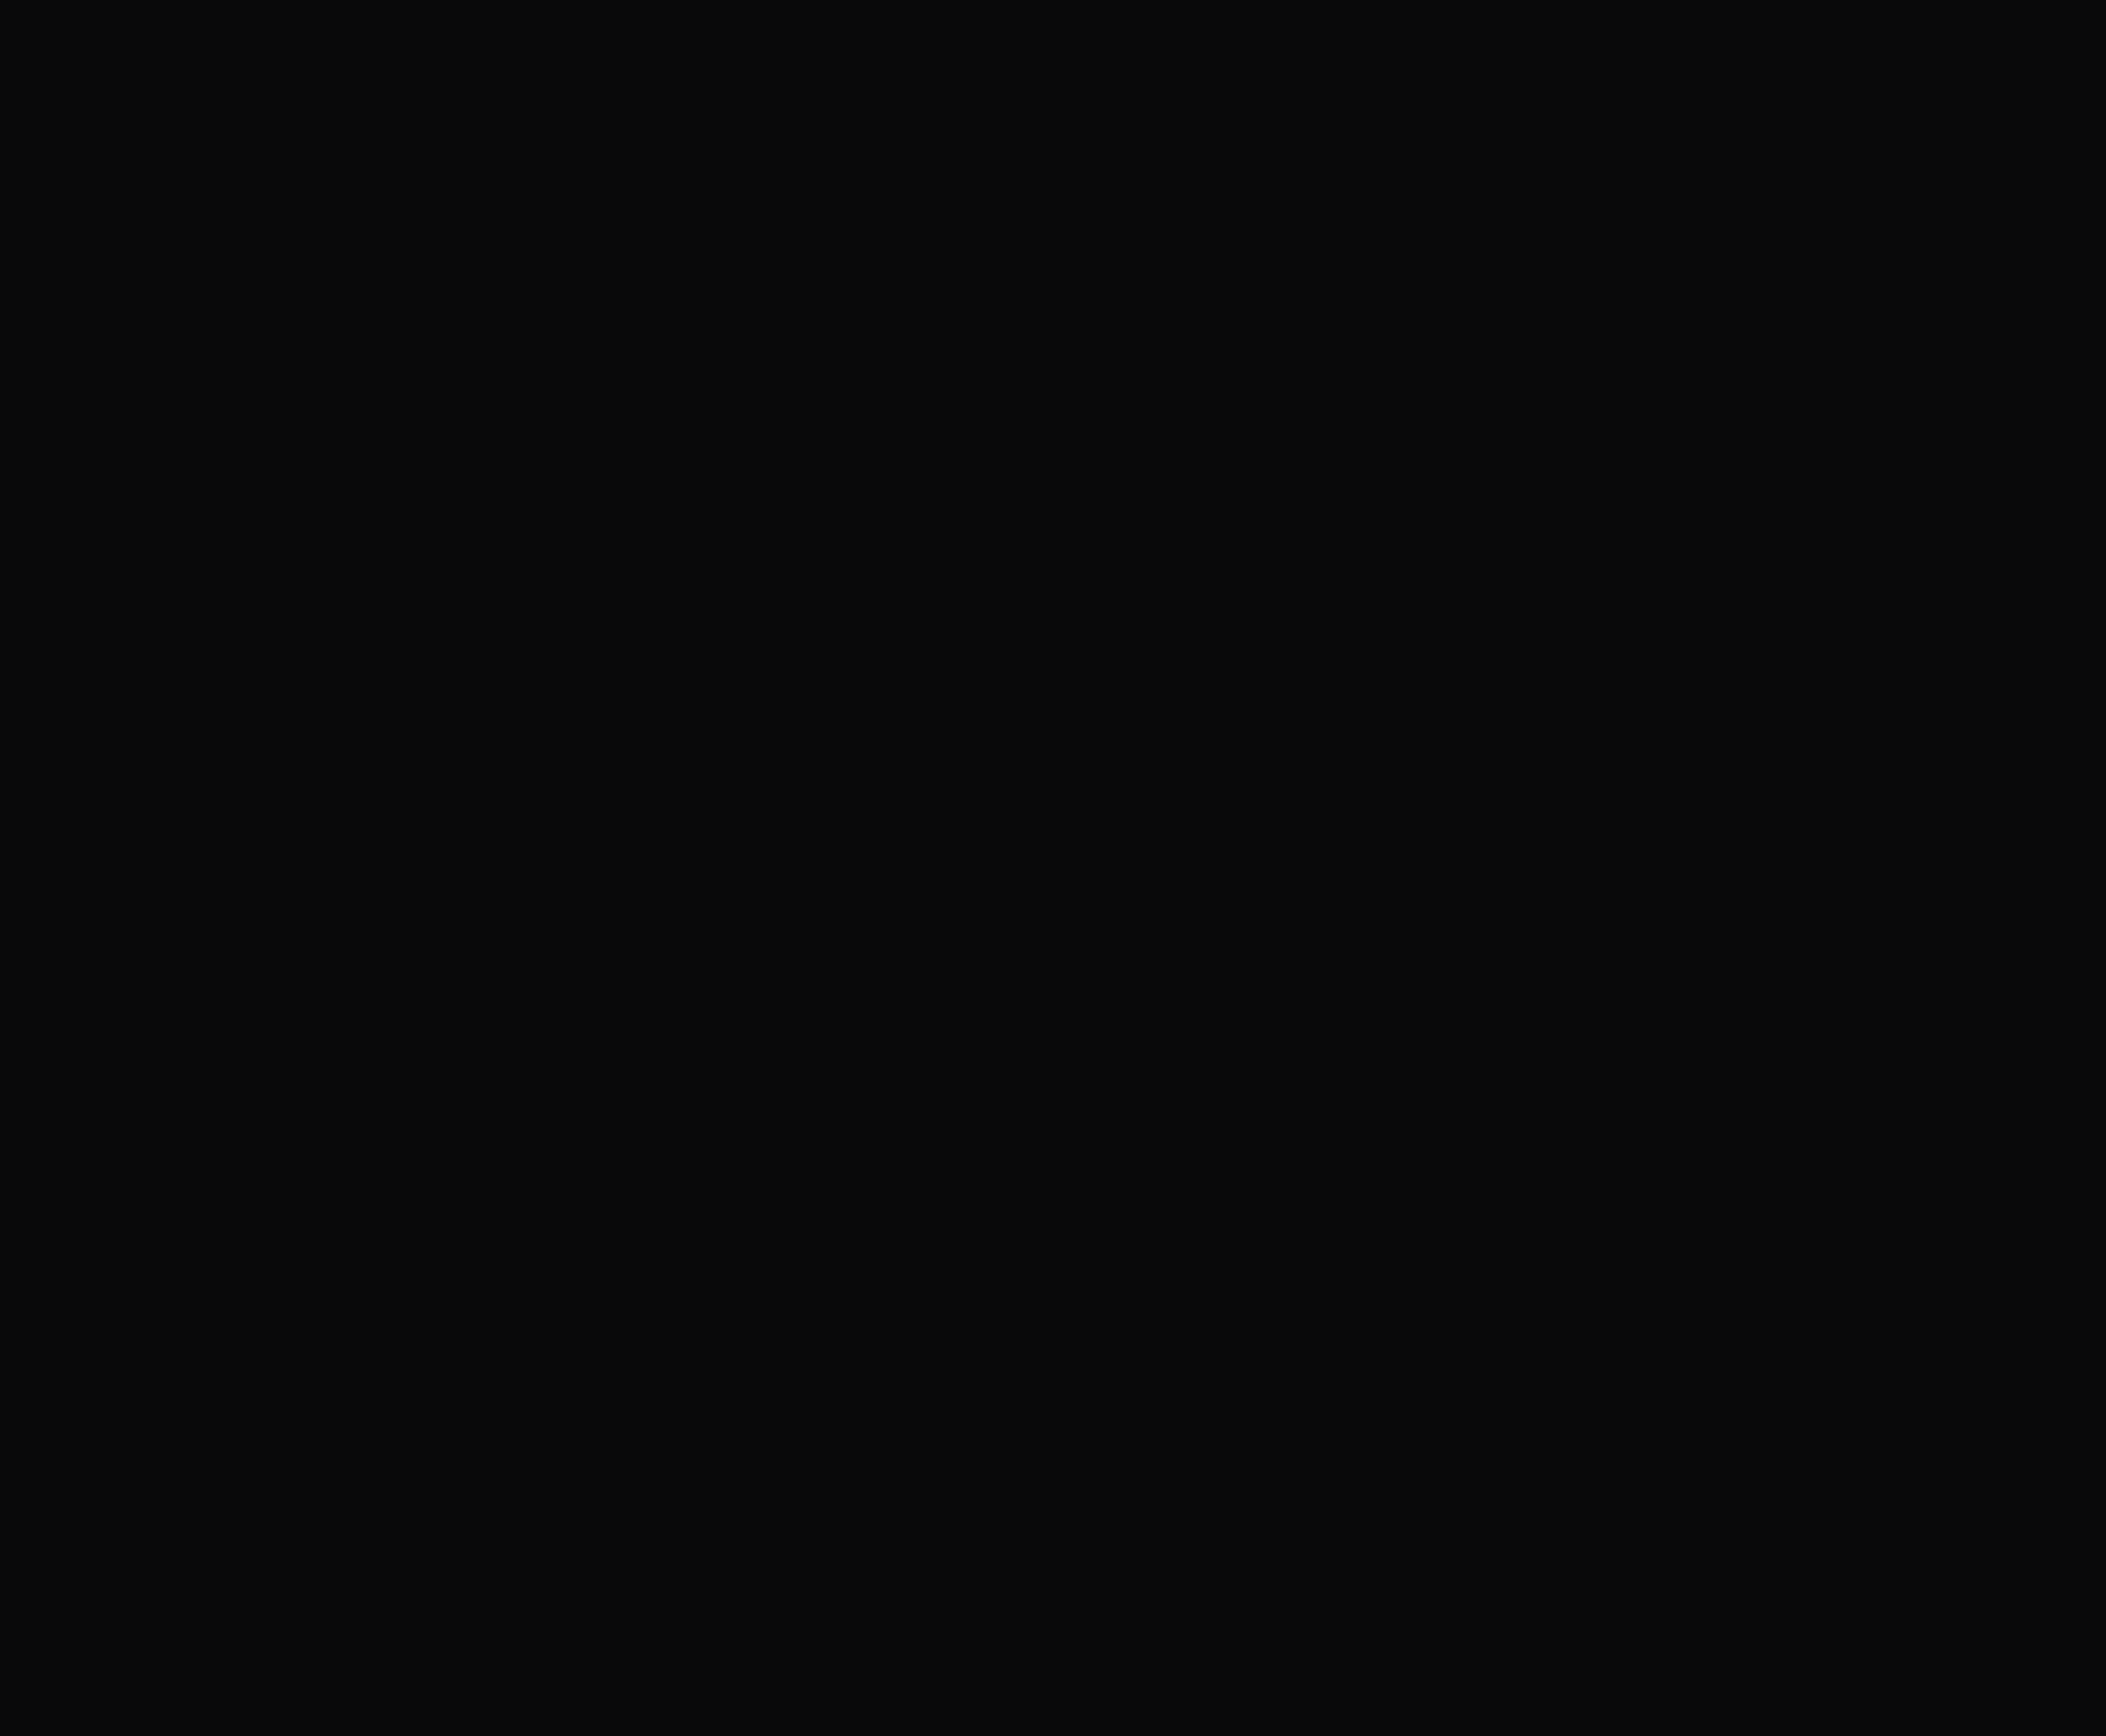

In [10]:
Image.fromarray(reprojections[0].numpy())

In [7]:
# images_on_mesh = Path('/workspace/pixel-perfect-sfm/rgbd_experiments/images_on_mesh')
# images_on_mesh.mkdir(parents=True, exist_ok=True)


# pathname = images_on_mesh / f'{object_name}/pixloc_exp_1_1'
# pathname.mkdir(parents=True, exist_ok=True)

# for view_i in tqdm(view_ids):
#     img = Image.fromarray(reprojections[view_i].numpy())
#     img.save(f'{pathname}/{view_i:04}.png'); del img